# タクシーマッチング問題
ここでは、目的関数と制約条件を両方用いる問題の例としてタクシーマッチング問題を解いてみましょう。

タクシーマッチング問題とは、複数名の顧客と複数台のタクシーの位置がそれぞれ与えられている場合に、配車コストを最小化する問題です。

配車コストには様々な定義が考えられますが、ここでは簡単のためタクシーと顧客間の総距離とします。タクシーと顧客のマッチングを行い、それぞれのタクシーと向かう先の顧客との距離の合計を最小化するように配車先の決定を行います。

## 問題の定式化

まず、ここでの問題の前提条件として、$N$人の顧客と、それと同じ数$N$台のタクシーがあるとします。インデックス $i, j = 0, 1, \cdots, N -1$ の顧客の座標 $(c_{i,x}, c_{i,y})$ とタクシーの座標 $(t_{j,x}, t_{j,y})$ が与えられているとします。これらの座標から、顧客 $i$ とタクシー $j$ の距離を 

$$
d_{ij} = \sqrt{(c_{i,x} - t_{j,x})^2 + (c_{i,y} - t_{j,y})^2}
$$ 

とします。

### 決定変数

顧客 $i$ とタクシー $j$ の関係は以下の二つのパターンに分けられます。

* 顧客 $i$ にタクシー $j$ が割り当てられる
* 顧客 $i$ にタクシー $j$ が割り当てられない

この二つの状態をバイナリ変数 $q_{ij}$ を用いて表現することにします。

* 顧客 $i$ に タクシー $j$ が割り当てられるとき、 $q_{ij} = 1$
* 顧客 $i$ に タクシー $j$ が割り当てられないとき、 $q_{ij} = 0$

|顧客 \ タクシー| $0$ | $1$ | ... | $N-1$|  
|:---:|:---:|:---:|:---:|:---:|
|$0$| $q_{0,0}$ | $q_{0,1}$ | ... | $q_{0,N-1}$|
|$1$| $q_{1,0}$ | $q_{1,1}$ | ... | $q_{1,N-1}$|
|$\vdots$| $\vdots$ | $\vdots$ | ... | $\vdots$|
|$N -1$| $q_{N-1,0}$ | $q_{N-1,1}$ | ... | $q_{N-1,N-1}$|

### 目的関数

上記の バイナリ変数を用いて、マッチングされた顧客とタクシーの合計の距離である目的関数は以下のように与えられます。  
変数 $q_{ij}$ は $1$ の場合に顧客 $i$ とタクシー $j$ がマッチングしているという意味なので、結果として $q_{ij} = 1$ となっている距離だけを足し上げています。

$$
\sum_{i, j=0}^{N-1}d_{ij}q_{ij}
$$

### 制約条件

次に制約条件を定めます。

まず、一人の顧客に必ず一台のタクシーを割り当てるので、顧客 $i$ に対して

$$
\sum_{j=0}^{N -1}q_{ij} = 1 
$$

という制約条件が必要となります。

さらに、一台のタクシーは必ず一人の顧客に割り当てられるので、タクシー $j$ に対して、

$$
\sum_{i=0}^{N -1}q_{ij} = 1 
$$

という制約条件も必要となります。


## 問題の実装

顧客とタクシーの位置座標が入力データとして必要となるので、顧客とタクシーの座標をランダムに生成して、顧客とタクシー全ての組み合わせの距離を計算する関数を作ります。

In [1]:
import numpy as np

# 顧客とタクシーの座標をランダムに生成し、顧客とタクシーの距離を計算
def gen_random_locations(N_customers: int, N_taxies: int):
    # 顧客の座標
    loc_customers = np.random.uniform(size=(N_customers, 2))

    # タクシーの座標
    loc_taxies = np.random.uniform(size=(N_taxies, 2))

    # 顧客とタクシーの距離を行列形式で計算
    all_diffs = np.expand_dims(loc_customers, axis=1) - np.expand_dims(
        loc_taxies, axis=0
    )
    distances = np.sqrt(np.sum(all_diffs ** 2, axis=-1))

    return loc_customers, loc_taxies, distances

また、可視化のために、顧客とタクシーの座標を与えると、それらの座標をプロットする関数も作ります。

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# 顧客とタクシーの位置を可視化
def show_plot(loc_customers: np.ndarray, loc_taxies: np.ndarray):
    markersize = 100
    plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(
        *zip(*loc_customers), label="Customers", marker="o", color="red", s=markersize
    )
    plt.scatter(
        *zip(*loc_taxies), label="Taxies", marker="^", color="blue", s=markersize
    )

    plt.legend(loc="upper right")
    plt.show()

顧客数とタクシー台数に対応する `N` を定め、それらの座標と距離を先ほど定義した `gen_random_locations` 関数で生成します。生成された結果をプロットして、顧客とタクシーの位置を可視化します。

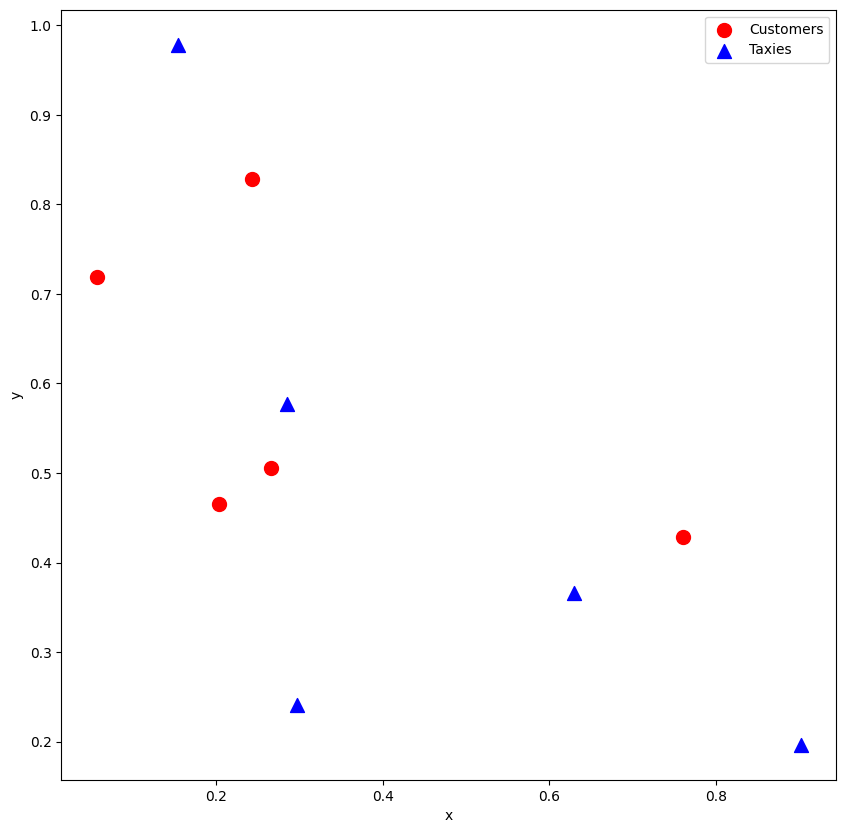

In [3]:
N = 5

Lc, Lt, d = gen_random_locations(N_customers=N, N_taxies=N)

show_plot(Lc, Lt)

### 二値多項式模型の構築

次に必要となる QUBO変数を定義します。$N$人の各顧客に対して $N$ 台のタクシーを対応させることを考えるので、$N\times N$の2次元配列として QUBO変数を以下のように定義します。

In [4]:
from amplify import BinarySymbolGenerator

# QUBO変数を生成
gen = BinarySymbolGenerator()
q = gen.array(N, N)

この QUBO変数を用いて 目的関数は以下のように得られます。

In [5]:
from amplify import sum_poly

cost = sum_poly(d * q)

次に、制約条件を定めます。

冒頭で説明した2つの制約条件を `one_hot` 関数を用いて以下のように表し、それらを足し上げて制約条件オブジェクトを構築します。

In [6]:
from amplify import sum_poly, BinaryQuadraticModel
from amplify.constraint import equal_to, one_hot

customer_has_one_taxi = sum(
    [one_hot(q[i]) for i in range(N)]
)
taxi_has_one_customer = sum(
    [one_hot(q[:, j]) for j in range(N)]
)

constraints = customer_has_one_taxi + taxi_has_one_customer

目的関数と制約条件を足すことで、最終的な二値多項式模型を以下のように得ることができます。

ここで、目的関数に対する制約条件の強さが重要になります。  
結論だけ述べると $d_{ij}$ の最大値にしておけば十分です。どの程度の強さが必要なのかに関する議論はここでは割愛します。

In [7]:
constraints *= np.amax(d)  # 強さを設定

# 目的関数と制約条件を結合する
model = cost + constraints

### イジングマシンの実行

イジングマシンのクライアントを `FixstarsClient` に設定し、さらにソルバーを作成して、以下のように問題を解きます。

In [8]:
from amplify import Solver
from amplify.client import FixstarsClient

# クライアントを設定
client = FixstarsClient()
client.parameters.timeout = 1000  # タイムアウト1秒
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください
client.parameters.outputs.num_outputs = 0

# ソルバーを設定
solver = Solver(client)

# 問題を解く
result = solver.solve(model)

得られた解は、以下のようにして確認することができます。

decode_solution 関数を用いて、始めに定義した変数に代入することで、最終的な解を得ることができます。

In [9]:
# result が空の場合は制約条件が満たされず、解が求まらない
if len(result) == 0:
    raise RuntimeError("Given constraint conditions are not satisfied")

for sol in result:
    values = sol.values
    energy = sol.energy
    print(f"energy = {energy}")
    print(f"q = {q.decode(values)}")

solution = np.array(q.decode(result[0].values))

energy = 1.3481189005968837
q = [[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


決定変数の配列は $i$ 番目の行の $j$ 番目の列に $1$ がある場合は、顧客 $i$ にタクシー $j$ を割り当てるという意味でした。したがって、以下のようにしてどの顧客にどのタクシーをマッチさせるかという情報を取得することができます。

In [10]:
customers = np.where(solution == 1)[0]
taxies = np.where(solution == 1)[1]
matches = list(zip(customers, taxies))

最後に、得られた顧客とタクシーのマッチングのデータを可視化します。

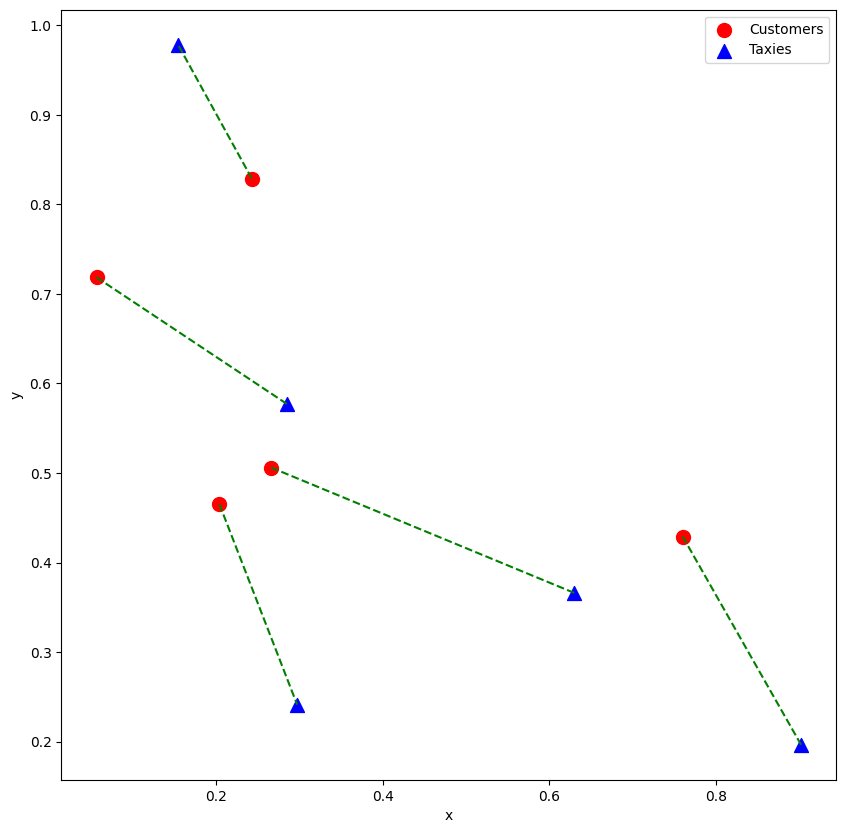

In [11]:
def plot_matching(loc_customers, loc_taxies, matches):
    markersize = 100
    plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(
        *zip(*loc_customers), label="Customers", marker="o", color="red", s=markersize
    )
    plt.scatter(
        *zip(*loc_taxies), label="Taxies", marker="^", color="blue", s=markersize
    )

    for i, j in matches:
        xc, yc = loc_customers[i]
        xt, yt = loc_taxies[j]
        plt.plot([xc, xt], [yc, yt], color="green", linestyle="--")

    plt.legend(loc="upper right")

    plt.show()


plot_matching(loc_customers=Lc, loc_taxies=Lt, matches=matches)

## タクシーの台数よりも顧客の人数のほうが少ない場合

ここでは、タクシーの台数よりも顧客の人数が少ない場合のタクシーマッチング問題を考えます。
この場合、各タクシーに割り当てられる顧客の数が0になる場合と1になる場合の両方を考慮して制約条件を立てる必要があります。
このような制約条件は不等式制約条件を用いて定式化できます。

$N_c$人の顧客と$N_t$台のタクシー($N_c < N_t$)とそれらの座標が与えられ、これまで通り顧客 $i$ と タクシー $j$ の距離を $d_{ij}$ とします。

### 目的関数

目的関数はこれまでと同様ですが、$N_c$ と $N_t$ が異なる値であることを考慮します。

$$
\sum_{i=0}^{N_c-1}\sum_{j=0}^{N_t - 1}d_{ij}q_{ij}
$$


### 制約条件

顧客よりもタクシーの台数が多いため、すべての顧客に対してタクシーが1台割り当てられます。
そのため、顧客$i$に対して、
$$
\sum_{j=0}^{N_{\rm t}-1}q_{ij} = 1 
$$
が成り立ちます。

一方、タクシーに対しては客が一人もいない場合があります。そこで、顧客の人数が0である場合と1である場合の両方を考慮して、不等式による制約を課します。
タクシー$j$に対して
$$
\sum_{i=0}^{N_{\rm c} -1}q_{ij} \le 1
$$
が成り立ちます。


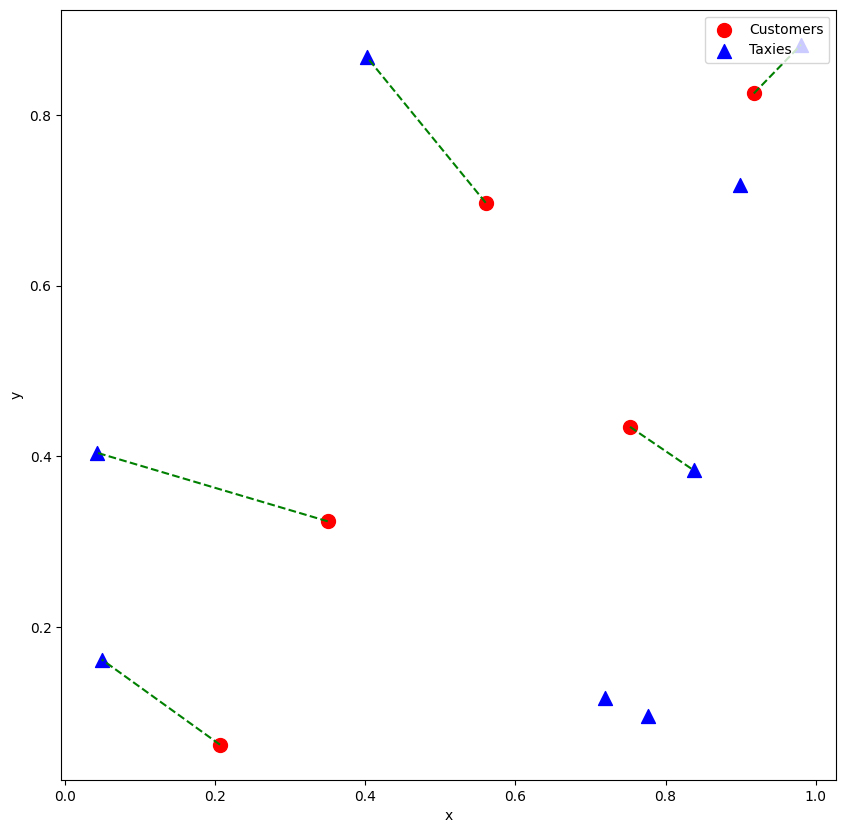

In [12]:
import numpy as np
from amplify import BinarySymbolGenerator, BinaryPoly, sum_poly, Solver
from amplify.constraint import less_equal, equal_to
from amplify.client import FixstarsClient

Nc = 5  # 顧客の数
Nt = 8  # タクシーの数

# 顧客の座標、タクシーの座標、顧客とタクシーの距離行列を生成
Lc, Lt, d = gen_random_locations(Nc, Nt)

# QUBO変数を生成
gen = BinarySymbolGenerator()
q = gen.array(Nc, Nt)

# 目的関数
cost = sum_poly(Nc, lambda i: sum_poly(Nt, lambda j: d[i][j] * q[i][j]))

############################################################################################
# 制約条件
# less_equal, equal_to, sum_poly を使うと便利です
############################################################################################

customer_has_one_taxi = sum(
    [equal_to(sum_poly(Nt, lambda j: q[i][j]), 1) for i in range(Nc)]
)

taxi_has_one_or_less_customer = sum(
    [less_equal(sum_poly(Nc, lambda i: q[i][j]), 1) for j in range(Nt)]
)

constraints = customer_has_one_taxi + taxi_has_one_or_less_customer

############################################################################################

# 目的関数と制約条件オブジェクトを足して論理模型を構築
constraints *= np.amax(d)  # 強さを設定
model = cost + constraints

# クライアントを設定
client = FixstarsClient()
client.parameters.timeout = 1000  # タイムアウト1秒
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください

# ソルバーを設定
solver = Solver(client)

# 問題を解く
result = solver.solve(model)

# result が空の場合は制約条件が満たさていない
if len(result) == 0:
    raise RuntimeError("Given constraint conditions are not satisfied")

solution = np.array(q.decode(result[0].values))

customers = np.where(solution == 1)[0]  # 顧客のインデックスのリスト
taxies = np.where(solution == 1)[1]  # 顧客のリスト
matches = list(zip(customers, taxies))  # マッチさせる顧客とタクシーのインデックス

# 顧客とタクシーのマッチングをプロット
plot_matching(loc_customers=Lc, loc_taxies=Lt, matches=matches)